# Modeling

This notebook takes the cleaned data from 'clean_crime.csv' and fits several models and finds which features are most important to classify the severity of a crime

In [1]:
import numpy as np
import pandas as pd
from sklearn.base import TransformerMixin
import matplotlib.pyplot as plt
import seaborn as sns
from sodapy import Socrata
import datetime
sns.set_style('whitegrid')

In [2]:
crimes = pd.read_csv('clean_crime.csv')

In [3]:
# these variables are numbers in the csv, but they are actually categorical data, so we cast them to strings

crimes['month'] = crimes['month'].astype(str)
crimes['time_of_day'] = crimes['time_of_day'].astype(str)
crimes['precinct'] = crimes['precinct'].astype(str)
crimes['city_housing'] = crimes['city_housing'].astype(str)

Next we will impute missing values, using averages for numeric data and the most common value for categorical data.

In [4]:
class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

crimes = DataFrameImputer().fit_transform(crimes)

In [5]:
# removing the target for our X set

X = crimes[['month', 'time_of_day', 'precinct', 'crime_completed', 'borough_name', 'premises',
                  'jurisdiction_code', 'latitude', 'longitude', 'victim_age_group', 'victim_race', 'victim_sex',
                  'suspect_age_group', 'suspect_race', 'suspect_sex', 'city_housing']]

In [6]:
# we need to get dummy variables, but only for the categorical variables, then we recombine

categorical_feature_mask = X.dtypes==object
numerical_features_mask = X.dtypes!=object
categorical_cols = X.columns[categorical_feature_mask].tolist()
numerical_cols = X.columns[numerical_features_mask].tolist()
X_cat = X[categorical_cols]
X_cat = pd.get_dummies(X_cat)
X = X_cat.join(X[numerical_cols])

In [7]:
# y is our target: 'offense_level'

y = crimes['offense_level']

In [8]:
y.value_counts() 

MISDEMEANOR    26395
FELONY         15634
VIOLATION       7971
Name: offense_level, dtype: int64

Looks like our classes are not equally distributed, if our model isn't performing well we might consider adding weight to violations.

Time to make some models!

Bagging:

In [9]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import metrics
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, r2_score

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=426, stratify=y, test_size=.2)

In [11]:
bag = BaggingClassifier(n_estimators=100, n_jobs=-1)
bag.fit(X_train,y_train)
bag_pred = bag.predict(X_test)

bagging_accuracy = metrics.accuracy_score(y_test, bag_pred)

In [12]:
print(metrics.confusion_matrix(y_test, bag_pred))
print(metrics.classification_report(y_test, bag_pred))

[[1186 1743  198]
 [ 993 3936  350]
 [ 221  956  417]]
              precision    recall  f1-score   support

      FELONY       0.49      0.38      0.43      3127
 MISDEMEANOR       0.59      0.75      0.66      5279
   VIOLATION       0.43      0.26      0.33      1594

    accuracy                           0.55     10000
   macro avg       0.51      0.46      0.47     10000
weighted avg       0.54      0.55      0.53     10000



Random Forest:

In [13]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth=3)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

rf_accuracy = metrics.accuracy_score(y_test, rf_pred)

In [14]:
print(metrics.confusion_matrix(y_test, rf_pred))
print(metrics.classification_report(y_test, rf_pred))

[[ 101 3026    0]
 [  25 5254    0]
 [   0 1594    0]]
              precision    recall  f1-score   support

      FELONY       0.80      0.03      0.06      3127
 MISDEMEANOR       0.53      1.00      0.69      5279
   VIOLATION       0.00      0.00      0.00      1594

    accuracy                           0.54     10000
   macro avg       0.44      0.34      0.25     10000
weighted avg       0.53      0.54      0.39     10000



/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

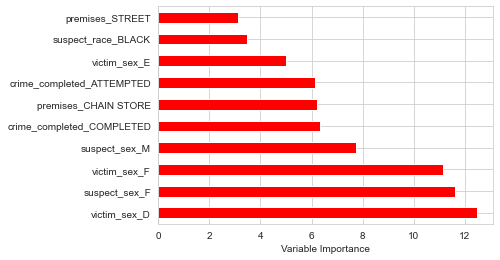

In [15]:
Importance = pd.DataFrame({'Importance':rf.feature_importances_*100}, index=X_train.columns)
Importance = Importance.iloc[rf.feature_importances_ > 0,:]
Importance = Importance.sort_values('Importance', axis=0, ascending=True)
Importance.sort_values('Importance', axis=0, ascending=False).head(10).plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

By this, we note that 'victim_sex_D', meaning that the victim wasn't a person but in fact a business or organization, is the most important. We also note that victim and suspect gender, and to a lesser extent, race, were significant to the model. 

Gradient Boosting:

In [16]:
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=.1)
gb.fit(X_train, y_train)
gb_pred = gb.predict(X_test)

gb_accuracy = metrics.accuracy_score(y_test, gb_pred)

In [17]:
print(metrics.confusion_matrix(y_test, gb_pred))
print(metrics.classification_report(y_test, gb_pred))

[[ 448 2593   86]
 [ 232 4885  162]
 [  41 1290  263]]
              precision    recall  f1-score   support

      FELONY       0.62      0.14      0.23      3127
 MISDEMEANOR       0.56      0.93      0.70      5279
   VIOLATION       0.51      0.16      0.25      1594

    accuracy                           0.56     10000
   macro avg       0.56      0.41      0.39     10000
weighted avg       0.57      0.56      0.48     10000



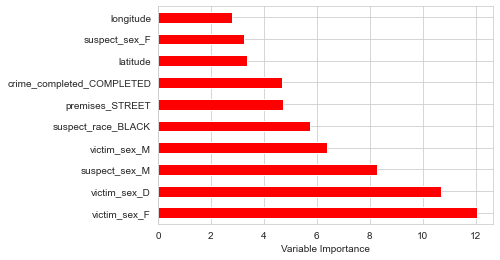

In [18]:
Importance = pd.DataFrame({'Importance':gb.feature_importances_*100}, index=X_train.columns)
Importance = Importance.iloc[gb.feature_importances_ > 0,:]
Importance = Importance.sort_values('Importance', axis=0, ascending=True)
Importance.sort_values('Importance', axis=0, ascending=False).head(10).plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

Once again 'victim_sex_D' was pretty high up, but this time it is overtaken by 'victim_sex_F'. Most of the same variables are present, though in different orders. Interestingly, the gradient boosting model was able to make good use of the latitude and longitude variables, indicating that location is significant in classifying the severity of crimes.

In [19]:
# Comparisons

def accuracy_compare_models(models):
    return sorted(models.items(), key = lambda kv:(kv[1], kv[0]), reverse= True)

accuracy = {'Bagging': bagging_accuracy, 'Random Forest': rf_accuracy, 'Gradient Boosting': gb_accuracy} 
print('Best overall models by highest accuracy: ', accuracy_compare_models(accuracy), '\n')


Best overall models by highest accuracy:  [('Gradient Boosting', 0.5596), ('Bagging', 0.5539), ('Random Forest', 0.5355)] 

